In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from cartopy.io.img_tiles import OSM
import cartopy


In [3]:
from experiments import SensorPlacement
from experiments import utilities as utils
from bayesinverse import Regression
from emissions import WK84_MASK, data_loader, GRAL, GK_MASK, transform_to_WK84

import robiplotipy.experiments.sensor_placement as plt_exp
from robiplotipy import PlotEnv


In [4]:
config_path = config_path = Path(
    "/home/rmaiwald/code/Experiments/experiments/sensor_placement/config.yaml"
)

exp = SensorPlacement(config_path)


sensors 0.012008190155029297
emissions 1.517284244298935
transport 5.010899096727371


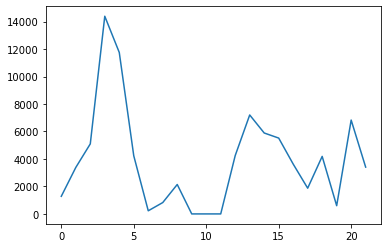

In [5]:
tno_cadastre_source_ids = list(range(25, 47))
plt.plot(exp.emissions.get_absolute()[tno_cadastre_source_ids])


In [6]:
meteo_seed = 20
n_processes = 40
exp.K = exp.transport.get_transport(
    exp.sensors.n_sensors,
    exp.sensors.get_index(),
    exp.emissions,
    n_processes=n_processes,
    seed=meteo_seed,
)


In [ ]:
n_mc = 500
n_time = 100


In [24]:
n_sample_list = [9, 12, 16, 20, 25]
# n_sample_list = [4, 16, 25]
information_dict = {}
error_reduction_dict = {}
relative_gain_dict = {}
dof_dict = {}
sensor_ids_dict = {}
for n_sample in n_sample_list:
    print(n_sample)
    information_dict[n_sample] = []
    error_reduction_dict[n_sample] = []
    relative_gain_dict[n_sample] = []
    dof_dict[n_sample] = []
    sensor_ids_dict[n_sample] = []
    for i in range(n_mc):
        sensor_ids = exp.sensors.get_sample_ids(n_sample)
        time_ids = exp.transport.get_time_ids(time=n_time)
        reg = Regression(
            y=utils.stack_xr(
                exp.K.isel(sensor=sensor_ids, time_measurement=time_ids)
                @ exp.emissions.truth
                + exp.sensors.get_noise(n_sample).isel(time_measurement=time_ids)
            ).values,
            K=utils.stack_xr(
                exp.K.isel(sensor=sensor_ids, time_measurement=time_ids)
            ).values,
            x_prior=utils.stack_xr(exp.emissions.prior).values,
            x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
            y_covariance=utils.stack_xr(
                exp.sensors.get_covariance().isel(
                    sensor=sensor_ids, time_measurement=time_ids
                )
            ).values,
        )
        reg.fit()
        information_dict[n_sample].append(reg.get_information_content())
        error_reduction_dict[n_sample].append(reg.get_error_reduction())
        relative_gain_dict[n_sample].append(
            reg.get_relative_gain(utils.stack_xr(exp.emissions.truth).values)
        )
        dof_dict[n_sample].append(reg.get_dof_signal())
        sensor_ids_dict[n_sample].append(sensor_ids)


9
12
16
20
25


In [25]:
best_information_dict = {}
best_error_reduction_dict = {}
best_relative_gain_dict = {}
best_dof_dict = {}
for n_sample in n_sample_list:
    print(n_sample)
    best_information_dict[n_sample] = []
    best_error_reduction_dict[n_sample] = []
    best_relative_gain_dict[n_sample] = []
    best_dof_dict[n_sample] = []
    exp.sensors.set_n_sensors(n_sample)
    exp.K = exp.transport.get_transport(
        exp.sensors.n_sensors,
        exp.sensors.get_index(),
        exp.emissions,
        n_processes=n_processes,
        seed=meteo_seed,
    )

    for i in range(n_mc):
        time_ids = exp.transport.get_time_ids(time=n_time)
        reg = Regression(
            y=utils.stack_xr(
                exp.K.isel(time_measurement=time_ids) @ exp.emissions.truth
                + exp.sensors.get_noise().isel(time_measurement=time_ids)
            ).values,
            K=utils.stack_xr(exp.K.isel(time_measurement=time_ids)).values,
            x_prior=utils.stack_xr(exp.emissions.prior).values,
            x_covariance=utils.stack_xr(exp.emissions.prior_covariance).values,
            y_covariance=utils.stack_xr(
                exp.sensors.get_covariance().isel(time_measurement=time_ids)
            ).values,
        )
        reg.fit()
        best_information_dict[n_sample].append(reg.get_information_content())
        best_error_reduction_dict[n_sample].append(reg.get_error_reduction())
        best_relative_gain_dict[n_sample].append(
            reg.get_relative_gain(utils.stack_xr(exp.emissions.truth).values)
        )
        best_dof_dict[n_sample].append(reg.get_dof_signal())


9
loop start 30.6870289593935
loop end 30.793868020176888
12
loop start 27.3549435287714
loop end 27.455034613609314
16
loop start 29.242845445871353
loop end 29.352811485528946
20
loop start 28.835556149482727
loop end 28.944049790501595
25
loop start 28.27510803937912
loop end 28.38168865442276


In [29]:
# Store/ load data
exp.data["information_dict"] = information_dict
exp.data["error_reduction_dict"] = error_reduction_dict
exp.data["relative_gain_dict"] = relative_gain_dict
exp.data["dof_dict"] = dof_dict
exp.data["best_information_dict"] = best_information_dict
exp.data["best_error_reduction_dict"] = best_error_reduction_dict
exp.data["best_relative_gain_dict"] = best_relative_gain_dict
exp.data["best_dof_dict"] = best_dof_dict
exp.data["sensor_ids_dict"] = sensor_ids_dict
exp.pickle_data()
